In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1012. Allostatic Load/P1012.3. Analyses/P1012.3.2. Ordinal Regression/Output')
cur_date = "060424"

library(readxl)
library(openxlsx)
library(tidyverse)
library(ordinalNet)
library(reshape2)
library(ggpubr)

# reading in file
#biomarker_df = data.frame(read_excel("Input/Allostatic_Mediator_Data_050824.xlsx", sheet = 2))
bp_df = data.frame(read_excel("Input/Allostatic_Mediator_Data_050824.xlsx", sheet = 4)) 
subject_info_df = data.frame(read_excel("Input/Subject_Info_050824.xlsx", sheet = 2))
mediator_scores_df = data.frame(read_excel("Input/Mediator_Scores_BP_Subjects_060324.xlsx"))
#mediator_scores_df$Race = as.character(mediator_scores_df$Race)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
head(bp_df)
head(subject_info_df)
head(mediator_scores_df)

,Subject_ID,Systolic,Diastolic,BP_Classification
,<chr>,<dbl>,<dbl>,<chr>
1,CS_M_21_W_5,114,70,N
2,CS_M_24_W_8,118,71,N
3,CS_M_25_W_10,121,83,E
4,CS_M_28_W_16,115,74,N
5,CS_M_29_W_17,118,80,N
6,CS_F_31_B_21,112,77,N


,Study,Original_Subject_Number,Subject_ID,Subject_Number,Smoking_Status,Sex,Age,Race
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1,FM2,97,CS_M_18_B_1,1,CS,M,18,B
2,FM2,99,CS_F_20_W_2,2,CS,F,20,W
3,FM2,101,CS_F_20_W_3,3,CS,F,20,W
4,FM2,98,CS_F_21_W_4,4,CS,F,21,W
5,TCORS LAIV,39,CS_M_21_W_5,5,CS,M,21,W
6,FM2,100,CS_F_22_W_6,6,CS,F,22,W


,Variable,Subject_ID,Mediator_Score,Smoking_Status,Race
,<chr>,<chr>,<dbl>,<chr>,<chr>
1,Cortisol,CS_M_21_W_5,0.24743096,NA,NA
2,Cortisol,CS_M_24_W_8,0.31083055,NA,NA
3,Cortisol,CS_M_25_W_10,0.13144609,NA,NA
4,Cortisol,CS_M_28_W_16,0.06754252,NA,NA
5,Cortisol,CS_M_29_W_17,0.44649218,NA,NA
6,Cortisol,CS_F_31_B_21,0.21687581,NA,NA


In this analysis, we're using [ordinal regression](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/ordinal-regression/) to predict blood pressure classification using mediator scores from 18 biomarkers. 

Starting by combining the dataframes. The `mediator_scores_df` needs to be split for each covariate group tested.

In [3]:
# splitting the df based on group and race, to make the code more efficient
split_mediator_df = mediator_scores_df %>%
    group_by(Smoking_Status, Race) %>%
    # splitting the df based on those variables
    group_split()

no_covariates_df = split_mediator_df[[4]]
smoker_df = split_mediator_df[[2]]
nonsmoker_df = split_mediator_df[[6]]
black_nonsmoker_df = split_mediator_df[[5]]
black_smoker_df = split_mediator_df[[1]]
white_nonsmoker_df = split_mediator_df[[7]]
white_smoker_df = split_mediator_df[[3]]

# # viewing one of the dataframes 
head(black_nonsmoker_df)

Variable,Subject_ID,Mediator_Score,Smoking_Status,Race
<chr>,<chr>,<dbl>,<chr>,<chr>
Cortisol,NS_F_21_B_37,0.4416750,NS,B
Cortisol,NS_F_21_B_39,0.1358074,NS,B
Cortisol,NS_F_27_B_50,1.0000000,NS,B
Cortisol,NS_F_28_B_53,0.8294634,NS,B
Cortisol,NS_F_32_B_56,0.4883275,NS,B
Cortisol,NS_F_32_B_57,0.5678661,NS,B


In [18]:
# creating a vector for variables that increase atherosclerotic risk
# HDL decreases risk
allostatic_load_biomarkers = c('Cortisol','Noradrenaline','Epinephrine','Hba1c','Fibrinogen','CRP', 'HDL')

ordinal_regression = function(dataset){
    # add words!!!!!
    # creating 1 df
    ordinal_regression_df = inner_join(bp_df[,c(1,4)], subject_info_df[,3:8]) %>%
        # adding mediator scores data
        inner_join(dataset[,1:3]) %>%
        # obtaining allostatic load biomarkers only
        filter(Variable %in% allostatic_load_biomarkers) %>%
        pivot_wider(names_from = Variable, values_from = Mediator_Score)
    
    # turning BP into a factor
    ordinal_regression_df$BP_Classification = factor(ordinal_regression_df$BP_Classification, levels = c("N", "E", "1", '2'))

    #reordering and removing some columns
    ordinal_regression_df = ordinal_regression_df[,c(1,8:14,2)]

    return(ordinal_regression_df)
    }

# calling fn
reg_df = ordinal_regression(no_covariates_df)
smoker_reg_df = ordinal_regression(smoker_df)
nonsmoker_reg_df = ordinal_regression(nonsmoker_df)
black_nonsmoker_reg_df = ordinal_regression(black_nonsmoker_df)
black_smoker_reg_df = ordinal_regression(black_smoker_df)
white_nonsmoker_reg_df = ordinal_regression(white_nonsmoker_df)
white_smoker_reg_df = ordinal_regression(white_smoker_df)

Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`
Joining with `by = join_by(Subject_ID)`


In [27]:
# creating a vector of booleans that specifies whether or not the coefficient should be
# positive (TRUE) or negative (FALSE), only HDL will be negative
biomarker_coefficients = c(rep(TRUE, ncol(reg_df) - 2))

estimateOrdWeights <- function(dataset, response, coefficients_magnitude){
    # """
    # Creating a function to run ordinal regression to estimate ordinal weights of mediator data based
    # on blood pressure classification
    # :param (input): wide df with biomarker data, response variable, magnitude of the coefficients
    # :output: 1 df with the ordinal weights
    # """
    
    # setting seed for reproducibility
    set.seed(12)
    
    #get number of response levels
    NoBins <- length(unique(dataset[[response]]))

    #get number of features or slices
    noSlices <- ncol(dataset) - 2

    # HDL needs to be negative so we'll make all the values negative
    dataset$HDL = dataset$HDL * -1
    
    # obtaining the features and converting into a matrix
    feature_data <- as.matrix(dataset[,c(2:(ncol(dataset) - 1))])

    # ordinal regression
    # positiveID specifies whether or not each coefficient for each ind. variable should be constrained to be non-negative
    regression_model <- ordinalNet(feature_data, dataset[[response]], positiveID = coefficients_magnitude, 
                            # lambdaVals defines how quickly your coefficients drop to 0
                            # keeping it at 0 tries to minimize feature reduction
                            # maxiterout defines the number of iterations before it stops
                         lambdaVals = 0, maxiterOut = 150)
    testW <- regression_model$coefs[NoBins:(noSlices + NoBins - 1)]

    # rescaling the coefficients so that they sum to 1
    normalizer = 1/sum(testW)
    rescaled_weight <- testW * normalizer

    # adding the variable names back in 
    test_weights_df = data.frame(Variable = colnames(feature_data), Coefficient = rescaled_weight) %>%
        arrange(-Coefficient) 
    
    return(test_weights_df)
}

# calling fn
weights_df = estimateOrdWeights(reg_df, 'BP_Classification', biomarker_coefficients)
smoker_weights_df = estimateOrdWeights(smoker_reg_df, 'BP_Classification', biomarker_coefficients)
nonsmoker_weights_df = estimateOrdWeights(nonsmoker_reg_df, 'BP_Classification', biomarker_coefficients)
black_nonsmoker_weights_df = estimateOrdWeights(black_nonsmoker_reg_df, 'BP_Classification', biomarker_coefficients)
black_smoker_weights_df = estimateOrdWeights(black_smoker_reg_df, 'BP_Classification', biomarker_coefficients)
white_nonsmoker_weights_df = estimateOrdWeights(white_nonsmoker_reg_df, 'BP_Classification', biomarker_coefficients)
white_smoker_weights_df = estimateOrdWeights(white_smoker_reg_df, 'BP_Classification', biomarker_coefficients)

weights_df

Warning message in mirlsNet(xList, yMat, alpha, penaltyFactors, positiveID, linkfun, :
“Reached outer loop iteration limit before convergence for at least one lambda value. Consider increasing maxiterOut.”
Warning message in mirlsNet(xList, yMat, alpha, penaltyFactors, positiveID, linkfun, :
“Reached outer loop iteration limit before convergence for at least one lambda value. Consider increasing maxiterOut.”


Variable,Coefficient
<chr>,<dbl>
Epinephrine,0.55594942
Fibrinogen,0.25770925
Noradrenaline,0.15662389
Cortisol,0.02971744
Hba1c,0.00000000
CRP,0.00000000
HDL,0.00000000


Based on the overall results with all 34 subjects, we can see that epinephrine had the largest (56%) contribution to blood pressure classification, while 3 variables were constrained to 0 having no impact on BP classification.

# Allostatic Load Calculation using Linear Regression

Now that we have these weights from the ordinal regression, we'll use a linear regression to calculate allostatic load scores for each subject using both the previously calculated mediator scores multiplied the ordinal weight for the 7 allostatic load biomarkers (cortisol, noradrenaline, epinephrine, HDL, Hba1c, fibrinogen, and CRP). The formula looks like...

Allostatic Load = Cortisol ordinal weight * Cortisol score + CRP ordinal weight * CRP score...

In [33]:
allostatic_load = function(ordinal_weights_df, mediator_scores_df, covariate){
    # add words!!
    
    # combining the mediator scores with the ordinal weights into one dataframe
    wider_weights_df = dcast(mediator_scores_df, Variable ~ Subject_ID, value.var = "Mediator_Score") %>% 
        inner_join(ordinal_weights_df) %>%
        column_to_rownames("Variable")

    # multiplying the value of the mediator in each row by its respective ordinal
    # weight found in the last column
    multiplication_df = wider_weights_df %>%
        select(-Coefficient) %>%
        mutate(across(contains("_"), ~.x*wider_weights_df$Coefficient))

    # calculating allostatic load by summing by the columns
    allostatic_load_df = data.frame(Allostatic_Load = apply(multiplication_df, 2, sum)) %>%
        arrange(-Allostatic_Load) %>%
        # adding a col that denotes the stratification
        mutate(Stratification = covariate)

    return(allostatic_load_df)
    }

# calling fn
all_allostatic_df = allostatic_load(weights_df, no_covariates_df, "None")
smoker_allostatic_df = allostatic_load(smoker_weights_df, smoker_df, "CS")
nonsmoker_allostatic_df = allostatic_load(nonsmoker_weights_df, nonsmoker_df, "NS")
black_nonsmoker_allostatic_df = allostatic_load(black_nonsmoker_weights_df, black_nonsmoker_df, "NS + B")
black_smoker_allostatic_df = allostatic_load(black_smoker_weights_df, black_smoker_df, "CS + B")
white_nonsmoker_allostatic_df = allostatic_load(white_nonsmoker_weights_df, white_nonsmoker_df, "NS + W")
white_smoker_allostatic_df = allostatic_load(white_smoker_weights_df, white_smoker_df, "CS + W")

head(all_allostatic_df)

Joining with `by = join_by(Variable)`
Joining with `by = join_by(Variable)`
Joining with `by = join_by(Variable)`
Joining with `by = join_by(Variable)`
Joining with `by = join_by(Variable)`
Joining with `by = join_by(Variable)`
Joining with `by = join_by(Variable)`


,Allostatic_Load,Stratification
,<dbl>,<chr>
NS_F_27_B_50,0.6464005,None
CS_M_28_W_16,0.6365527,None
NS_F_23_W_41,0.6262244,None
NS_F_38_B_61,0.6007436,None
NS_F_32_B_57,0.5484291,None
NS_F_21_B_37,0.5341852,None


In [34]:
# combining into 1 df 
allostatic_df = rbind(all_allostatic_df, smoker_allostatic_df, nonsmoker_allostatic_df, black_nonsmoker_allostatic_df,
                      black_smoker_allostatic_df, white_nonsmoker_allostatic_df, white_smoker_allostatic_df)

head(allostatic_df)

,Allostatic_Load,Stratification
,<dbl>,<chr>
NS_F_27_B_50,0.6464005,None
CS_M_28_W_16,0.6365527,None
NS_F_23_W_41,0.6262244,None
NS_F_38_B_61,0.6007436,None
NS_F_32_B_57,0.5484291,None
NS_F_21_B_37,0.5341852,None


In [50]:
# using descriptive stats to explore differences
five_sum_df = data.frame()
for (i in 1:length(unique(allostatic_df$Stratification))){
    filtered_df = allostatic_df %>%
        filter(Stratification == unique(allostatic_df$Stratification)[i])

    values_vector = c(fivenum(filtered_df$Allostatic_Load), filtered_df$Stratification[i])
    five_sum_df = rbind(five_sum_df, values_vector)

    # adding col names
    colnames(five_sum_df) = c("Min", "1st Quartile", "Median", "Mean", "3rd Quartile", "Max")

    }

five_sum_df

Min,1st Quartile,Median,Mean,3rd Quartile,Max
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0.0473154587990443,0.222031356751587,0.317579370204926,0.475603124702992,0.646400486283046,None
0.00668567724376996,0.115447541196695,0.316473780126944,0.484824715098937,0.95374043422709,CS
0.00653572026952985,0.112536686654793,0.24364024542474,0.447067958069341,0.912865077341964,NS
0.172888910618316,0.232367055706593,0.478969231378742,0.581981242652988,0.84968128742046,NS + B
-0.144220781054255,0.217389501360755,0.384699912165989,0.471906221240395,0.850777032570847,CS + B
0.00979024072757351,0.142797974929403,0.193858020668922,0.805598402433754,0.989759180085761,NS + W
0.0259611216083772,0.165331487263094,0.243446644944437,0.575176003779962,0.802572290796885,CS + W


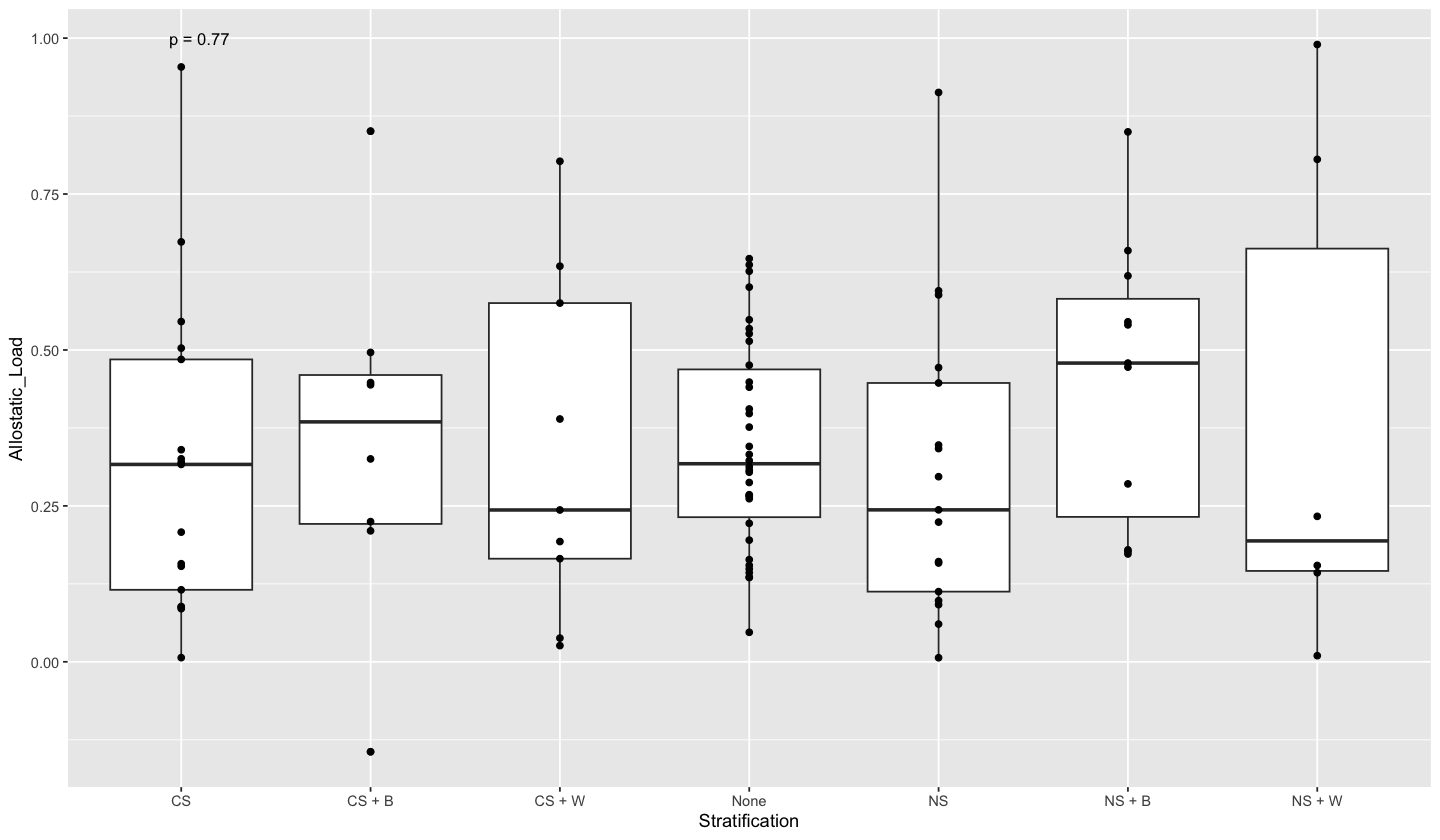

In [63]:
options(repr.plot.width=12, repr.plot.height=7) #changing size

ggplot(data = allostatic_df, aes(y = Allostatic_Load, x = Stratification)) + 
  geom_boxplot() +
  geom_point() + 

  stat_anova_test(wid = "Stratification", p.adjust.method = "none", label = "p = {p.format}", 
                     label.x.npc = "left", size = 3.5)
  

In [60]:
library(ggpubr)